# Introduction to VICE

Requirements: You need to have installed VICE and to specify its path as the variable VICE_path (see "Paths").
You need to have created a conda environment for VICE called "vice".


### Load libraries

In [62]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from matplotlib import pyplot as plt
%matplotlib inline

### Paths

In [2]:
# specify a path to where VICE package is installed
VICE_path = "../VICE/"

## Processing Data

In [3]:
# Read raw triplet data
triplets_raw = pd.read_csv("data/things48triplets.csv")
# View data
triplets_raw

,worker_no,exclude,item1,item2,item3,chosen_item,isrepeat,RT
0,1,0,telegraph,bumper,canvas,telegraph,0,12260
1,1,0,punching bag,tarantula,music box,tarantula,0,2450
2,1,0,telegraph,chariot,rolling pin,chariot,1,1916
3,1,0,rudder,bumper,washcloth,washcloth,0,2453
4,1,0,flagpole,bucket,pizza,pizza,0,4671
...,...,...,...,...,...,...,...,...
52267,121,0,candelabra,file,jet,candelabra,1,1632
52268,121,0,dice,tea,pizza,pizza,0,3525
52269,121,0,dice,canvas,telegraph,canvas,1,1606
52270,121,0,washcloth,dice,bookshelf,bookshelf,0,2083


In [4]:
# filter based on inclusion flag
triplets_filtered = triplets_raw.loc[triplets_raw['exclude'] == 0, ['item1', 'item2', 'item3', 'chosen_item']]

In [5]:
np.unique(["a","c","b"])

array(['a', 'b', 'c'], dtype='<U1')

In [6]:
def convert_triplets_to_apns(
    triplets_df, item_col_names=None, choice_col_name=None, item_names=None
):
    """
    Converts a dataframe containing triplet choices in the format (item1, item2, item3, choice)
    to a numpy integer array in the anchor-positive-negative (APN) format.

    Parameters
    ----------
    triplets_df : pandas.dataframe, with four columns containing item names.
    item_col_names : list of str.  A list of three column names for the three item columns.
        If None, then the first 3 columns are assumed to be the item columns.
    choice_col_name : str.  The column name for the choice column.
        If None, the 4th column is assumed to be the choice column.
    item_names : numpy.array of str.  
        The 0-indexed array where element i is the item name that will be mapped to integer i.
        If None, the sorted list of unique item names is used to construct the mapping.

    Returns
    -------
    apns : numpy.array containing triplets in apn format
    item_names : list of item names
    """
    assert len(triplets_df.columns) >= 4, "triplets_df must have at least 4 columns"
    if item_col_names is None:
        item_col_names = triplets_df.columns[:3]
    if choice_col_name is None:
        choice_col_name = triplets_df.columns[3]
    if item_names is None:
        item_names = np.unique(np.concatenate((
            triplets_df[item_col_names[0]],triplets_df[item_col_names[1]],triplets_df[item_col_names[2]],
            triplets_df[choice_col_name])))
    # dict for converting name to ID
    n2id = {n: i for i,n in enumerate(item_names)}
    item0 = triplets_df[item_col_names[0]].map(n2id)
    item1 = triplets_df[item_col_names[1]].map(n2id)
    item2 = triplets_df[item_col_names[2]].map(n2id)
    chosen = triplets_df[choice_col_name].map(n2id)
    choice = np.zeros(len(triplets_df))
    choice[item1 == chosen] = 1
    choice[item2 == chosen] = 2
    apns = np.zeros((len(triplets_df), 3), dtype=int)
    # APN assignment
    # choice anchor positive negative
    #      0      1        2        0
    #      1      0        2        1
    #      2      0        1        2
    apns[choice!=0, 0] = item0[choice!=0]
    apns[choice==0, 0] = item1[choice==0]
    apns[choice!=2, 1] = item2[choice!=2]
    apns[choice==2, 1] = item1[choice==2]
    apns[choice==0, 2] = item0[choice==0]
    apns[choice==1, 2] = item1[choice==1]
    apns[choice==2, 2] = item2[choice==2]
    return apns, item_names

In [7]:
apns, item_names = convert_triplets_to_apns(triplets_filtered)

### Explanation of APN format (Skippable)

The Anchor-positive-negative (APN) format is based on the two-forced choice task, in which the participant has to choose one out of two objects that is the most similar to the a query object, called the Anchor.  The Positive is the object chosen by the participant, and the Negative is object not chosen.  By listing the objects in the order of Anchor, Positive, and Negative, the APN format allows 2AFC trials to be presented compactly.

We adapted the APN format to the odd-one-out task, by considering the object chosen as odd-one-out to take a similar role of the Negative in the 2FC task.  Hence, in the row corresponding to the trial, we will put the chosen odd-one-out object in the third position (Negative), while the other two objects are placed in the first two positions (Anchor and Positive).

Let us look at one example.  In the 22nd row of the filtered triplets, we see a triplet where "furnace" was chosen as the odd-one-out among "trophy" and "headphones".

In [8]:
triplets_filtered.loc[22]

item1             furnace
item2              trophy
item3          headphones
chosen_item       furnace
Name: 22, dtype: object

Hence, in APN format, furnace should be listed as the third item.  We can confirm that this is the case in the APN format array.

In [9]:
item_names[apns[22]]

array(['trophy', 'headphones', 'furnace'], dtype=object)

Here is another example where "bowler hat", the third item, is the odd-one-out.  In this case, the ordering of the objects can remain the same for APN format.

In [10]:
triplets_filtered.loc[24]

item1                tuba
item2                knob
item3          bowler hat
chosen_item    bowler hat
Name: 24, dtype: object

In [11]:
item_names[apns[22]]

array(['trophy', 'headphones', 'furnace'], dtype=object)

We just saw examples where the first item or the third item were the odd-one-out.  Now here is an example where the second item was picked.

In [12]:
triplets_filtered.loc[26]

item1              bumper
item2               drain
item3          bowler hat
chosen_item         drain
Name: 26, dtype: object

In [13]:
item_names[apns[26]]

array(['bumper', 'bowler hat', 'drain'], dtype=object)

## Creating a training-test split

VICE expects the user to supply data that has been split into a larger training partition, and a smaller test partition.  VICE provides tools to select hyperparameters using performance on the test partition.

While developing the method, the authors used an approximately 90-10 training-test split (but maintaining a training set that was a multiple of 128, the batch size).  Users can feel free to use other sample size ratios.  However, the files must still be named according to the hardcoded convention of `train_90.txt`, `test_10.txt`.

In [14]:
from numpy.random import default_rng

def train_test_split(apns, seed=0, train_frac=0.9, batch_size=128, copy_apns=True):
    """
    Creates a training-test split from apns.

    Parameters
    ----------
    apns : numpy.array
        Triplet data in APN format.
    seed : int
        Random seed for shuffling, default 0.
    copy_apns : bool
        Whether to copy the apns array (to prevent the original array from getting shuffled).
    """
    if copy_apns:
        apns_copy = apns.copy()
    else:
        apns_copy = apns
    rng = default_rng(seed)
    rng.shuffle(apns_copy)
    ntrain = int(np.floor(train_frac * len(apns)/batch_size)) * batch_size
    apns_tr = apns_copy[:ntrain]
    apns_te = apns_copy[ntrain:]
    return apns_tr, apns_te

In [15]:
apns_tr, apns_te = train_test_split(apns, seed=2025)

In [16]:
apns_tr

array([[28, 17, 26],
       [25, 41, 11],
       [29, 24, 39],
       ...,
       [21, 14, 31],
       [32, 27,  1],
       [13, 24, 20]])

In [17]:
apns_te

array([[26, 40, 11],
       [ 3, 40,  1],
       [28, 12, 42],
       ...,
       [24, 28, 42],
       [24, 44, 25],
       [41, 13, 43]])

In [18]:
apns

array([[ 6, 10, 40],
       [33, 29, 38],
       [40, 34, 11],
       ...,
       [14, 40, 10],
       [47, 14,  3],
       [17, 35,  2]])

### Write train and test sets in VICE directory

In [19]:
!ls

LICENSE       README.md     data          example.ipynb


In [23]:
%cd $VICE_path

/Users/zhengchy/github/VICE


/Users/zhengchy/miniconda3/envs/torchbook/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [24]:
!ls


DEMO.ipynb              find_best_hypers.py     plots
LICENSE                 get_embeddings.sh       probas
README.md               main_inference.py       requirements.txt
__pycache__             main_optimization.py    results
bash_scripts            main_robustness_eval.py tests
create_things_splits.py main_tripletize.py      utils.py
data                    model                   visualization.py
embeddings              optimization
envs                    partition_triplets.py


In [25]:
cd data

/Users/zhengchy/github/VICE/data


In [27]:
mkdir tutorial_things48

In [28]:
cd tutorial_things48

/Users/zhengchy/github/VICE/data/tutorial_things48


In [30]:
np.savetxt("train_90.txt", apns_tr, fmt="%i")

In [31]:
np.savetxt("test_10.txt", apns_te, fmt="%i")

In [32]:
cd ../..

/Users/zhengchy/github/VICE


## Run VICE

In [38]:
!ls

DEMO.ipynb              find_best_hypers.py     plots
LICENSE                 get_embeddings.sh       probas
README.md               main_inference.py       requirements.txt
__pycache__             main_optimization.py    results
bash_scripts            main_robustness_eval.py tests
create_things_splits.py main_tripletize.py      utils.py
data                    model                   visualization.py
embeddings              optimization
envs                    partition_triplets.py


In [41]:
!conda run -n vice python main_optimization.py --task odd-one-out --triplets_dir data/tutorial_things48 --epochs 300 --burnin 100 --eta 0.001 --init_dim 50 --batch_size 128 --optim adam --mixture gaussian --mc_samples 10 --spike 0.25 --slab 1.0 --pi 0.5 --k 5 --ws 50 --steps 50 --device cpu --num_threads 1 --rnd_seed 2025 --verbose


...Could not find any .npy files for current modality.
...Now searching for .txt files.


Number of train batches: 303


...Creating directories.


====== Epoch: 01, Train acc: 0.457, Train loss: 1.289, Identified dimensions: 50 ======


====== Epoch: 02, Train acc: 0.559, Train loss: 1.179, Identified dimensions: 50 ======


====== Epoch: 03, Train acc: 0.587, Train loss: 1.109, Identified dimensions: 50 ======


====== Epoch: 04, Train acc: 0.603, Train loss: 1.069, Identified dimensions: 50 ======


====== Epoch: 05, Train acc: 0.608, Train loss: 1.043, Identified dimensions: 50 ======


====== Epoch: 06, Train acc: 0.615, Train loss: 1.025, Identified dimensions: 50 ======


====== Epoch: 07, Train acc: 0.618, Train loss: 1.010, Identified dimensions: 50 ======


====== Epoch: 08, Train acc: 0.621, Train loss: 0.999, Identified dimensions: 50 ======


====== Epoch: 09, Train acc: 0.621, Train loss: 0.991, Identified dimensions: 50 ======


====== Epoch: 10, Train acc: 0.622, Train

## Look at results

In [42]:
%cd $VICE_path

/Users/zhengchy/github/VICE


In [43]:
res = np.load("results/50d/adam/gaussian/0.25/1.0/0.5/seed2025/pruned_params.npz")

In [47]:
embed = res["pruned_loc"]

In [52]:
# print out top 5 names for each dimension
for i in range(embed.shape[1]):
    print("Dim. " + str(i) + " : " + ", ".join(item_names[np.argsort(-embed[:, i])[:5]]))

Dim. 0 : toolbox, camera, laptop, headphones, tape measure
Dim. 1 : file, headphones, camera, hammer, trigger
Dim. 2 : trophy, tuba, rolling pin, rudder, canister
Dim. 3 : table, bookshelf, bench, rudder, coaster
Dim. 4 : tape measure, flagpole, metal detector, bench, hammer
Dim. 5 : file, trigger, jet, hammer, bumper
Dim. 6 : turban, bag, clothes, bowler hat, washcloth
Dim. 7 : music box, tuba, tea, bench, bucket
Dim. 8 : table, laptop, candelabra, canvas, canister
Dim. 9 : tape measure, file, bucket, hammer, toolbox
Dim. 10 : music box, knob, telegraph, dice, canister
Dim. 11 : pizza, macadamia, tea, rolling pin, coaster
Dim. 12 : beaver, tarantula, chariot, turban, navel
Dim. 13 : trophy, tiara, candelabra, jet, flagpole
Dim. 14 : navel, plaster cast, turban, clothes, bowler hat
Dim. 15 : tea, pizza, drain, canister, knob
Dim. 16 : file, washcloth, rolling pin, clothes, furnace
Dim. 17 : furnace, hammer, rudder, toolbox, tape measure
Dim. 18 : hopscotch, doormat, canvas, washcloth, 

In [54]:
item_names

array(['bag', 'beaver', 'bench', 'bookshelf', 'bowler hat', 'bucket',
       'bumper', 'camera', 'candelabra', 'canister', 'canvas', 'chariot',
       'clothes', 'coaster', 'dice', 'doormat', 'drain', 'file',
       'flagpole', 'furnace', 'hammer', 'headphones', 'hopscotch', 'jet',
       'knob', 'laptop', 'macadamia', 'metal detector', 'mistletoe',
       'music box', 'navel', 'pizza', 'plaster cast', 'punching bag',
       'rolling pin', 'rudder', 'table', 'tape measure', 'tarantula',
       'tea', 'telegraph', 'tiara', 'toolbox', 'trigger', 'trophy',
       'tuba', 'turban', 'washcloth'], dtype=object)

In [55]:
img_fnames = [s.replace(" ","_") + ".jpg" for s in item_names]

In [58]:
imgs = []
for i in range(48):
    imgs.append(image.imread("../VICE_vignette/reference_images48/" + img_fnames[i]))

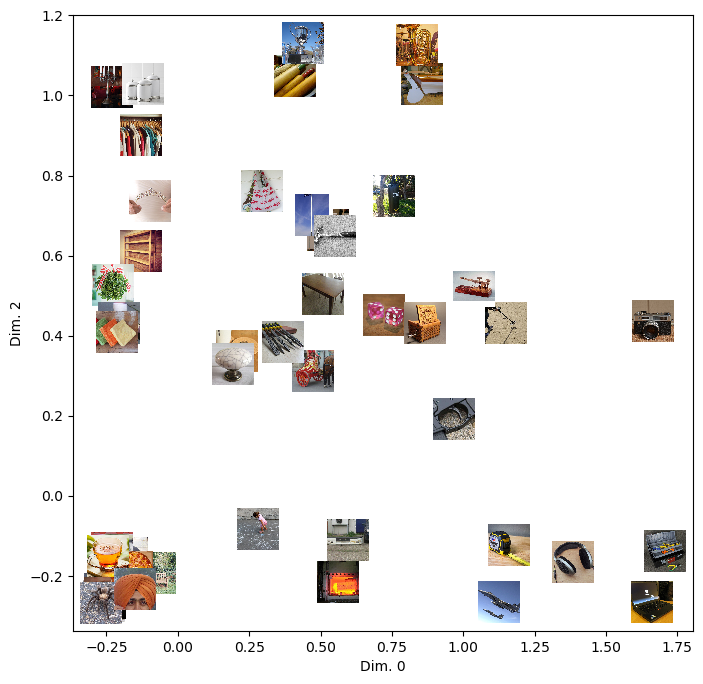

In [77]:
# plot scatterplot of these two dimensions
dim_x = 0
dim_y = 2
fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(embed[:, dim_x], embed[:, dim_y])
plt.xlabel("Dim. %i" % dim_x)
plt.ylabel("Dim. %i" % dim_y)
for i in range(48):
    img_size = imgs[i].shape[0]
    imagebox = OffsetImage(imgs[i], zoom = 30/img_size)
    ab = AnnotationBbox(imagebox, (embed[i, dim_x], embed[i, dim_y]), frameon = False)
    ax.add_artist(ab)